## Randall Mencias
## Juan Francisco Cisneros
## Josue Cardenas


# Proyecto Aprendizaje Automatico: Recomendacion de medicamentos

### INTRODUCCION
- El objetivo de este proyecto es predecir el mejor medicamento para una dada condicion. El algoritmo de aprendizaje se entrenó utilando una base de datos donde se podia encontrar un review de la medicacion para la condicion que se intentaba tratar. De esta manera se buscaba encontrar una relacion entre la condicion y el medicamento que se utilizaba para tratarla en conjunto con la calificacion que le daba el paciente a la medicacion.
- Con este objetivo en mente se decidio utilizar dos algortimos diferentes:
   - Logistic Regression
   - SVM(Support Vector Machine)
- Utilizando estos algortimos se pudo obtener las recomendaciones planificadas y se pudo comparar los datos entre ambos metodos para poder determinar y corrobar las respuestas obtenidas

#### Librerias

In [1408]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import transformers
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

import xgboost as xgb

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from numpy import mean, std




### ANALISIS EXPLORATORIO DE DATOS

Durante esta parte del proyecto se importo los datos a utilizar y se hizo un analisis de estos. Se busco datos principales como labels de cada dato y entre estos que datos podriann ser utiles para el entrenamiento y cuales podrian ser ignorados o eliminados.

In [1409]:
# Where data is stored
pathTest = "../Medicine_Recomendation-2/data/test.csv"
pathTrain = "../Medicine_Recomendation-2/data/train.csv"

# Read data
dfTest = pd.read_csv(pathTest)
dfTrain = pd.read_csv(pathTrain)

# Size of the train and test data
print("Train data size: ", dfTrain.shape)
print("Test data size: ", dfTest.shape)

Train data size:  (161297, 7)
Test data size:  (53200, 7)


In [1410]:
dfTrain.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2003-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [1411]:
dfTest.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,6,Medroxyprogesterone,Birth Control,"""This is a horrible shot!! I got my first shot...",1,24-Oct-15,3
2,15,Medroxyprogesterone,Birth Control,"""I&#039;m 24 and I&#039;ve been on this for ab...",9,16-Oct-15,7
3,17,Medroxyprogesterone,Endometriosis,"""I loved how convenient this was, one shot eve...",3,15-Oct-15,4
4,19,Medroxyprogesterone,Birth Control,"""I took this shot to be safe, I&#039;m a young...",7,14-Oct-15,5


#### Plot Columns

In [1412]:
print("Test data shape, Rows and Columns: ", dfTest.shape)
print("Train data shape, Rows and Columns: ", dfTrain.shape)
print()
print("Test data columns: ", dfTest.columns)
print("Train data columns: ", dfTrain.columns)

Test data shape, Rows and Columns:  (53200, 7)
Train data shape, Rows and Columns:  (161297, 7)

Test data columns:  Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')
Train data columns:  Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')


In [ ]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [ ]:
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53200 entries, 0 to 53199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53200 non-null  int64 
 1   drugName     53200 non-null  object
 2   condition    53200 non-null  object
 3   review       53200 non-null  object
 4   rating       53200 non-null  int64 
 5   date         53200 non-null  object
 6   usefulCount  53200 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.8+ MB


In [ ]:
dfTrain.describe()

,uniqueID,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [ ]:
# Check for missing values
dfTrain.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [ ]:
# Drop all rows with missing values
dfTrain.dropna(inplace=True)
dfTrain.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [ ]:
dfTest.describe()

,uniqueID,rating,usefulCount
count,53200.000000,53200.000000,53200.000000
mean,116465.986485,6.978289,28.170282
std,67001.804385,3.286389,36.284596
min,0.000000,1.000000,0.000000
25%,58371.500000,4.000000,6.000000
50%,116418.500000,8.000000,16.000000
75%,174645.250000,10.000000,36.000000
max,232284.000000,10.000000,949.000000


In [ ]:
# Check for missing values
dfTest.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [ ]:
print("Test data shape, Rows and Columns: ", dfTest.shape)
print("Train data shape, Rows and Columns: ", dfTrain.shape)

Test data shape, Rows and Columns:  (53200, 7)
Train data shape, Rows and Columns:  (160398, 7)


In [ ]:
dfAll = pd.concat([dfTrain,dfTest])


Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

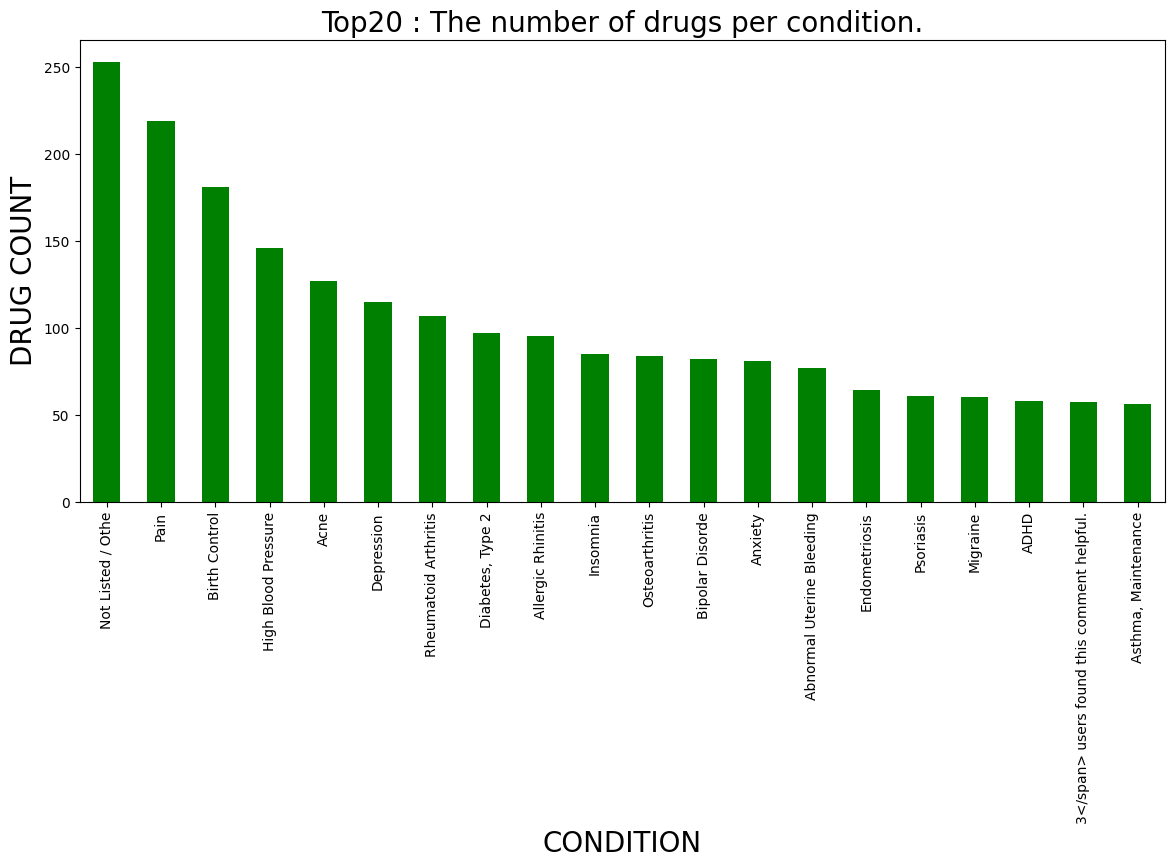

In [ ]:
condition_dn = dfAll.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("CONDITION", fontsize = 20)
plt.ylabel("DRUG COUNT", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

#### Drop all rows where the CONDITION is not in the top 5
- Based on the graph above, we choose to drop all the rows where the conditions is not in the top 5

In [ ]:
# Show all the conditions
dfAll['condition'].value_counts()

condition
Birth Control                                  38436
Depression                                     12164
Pain                                            8245
Anxiety                                         7812
Acne                                            7435
                                               ...  
unctional Gastric Disorde                          1
72</span> users found this comment helpful.        1
Hemangioma                                         1
Anti NMDA Receptor Encephalitis                    1
Pertussis Prophylaxis                              1
Name: count, Length: 909, dtype: int64

In [ ]:
# Drop all rows not correponding to [Birth Control, Depresion, Pain, Anxiety and Acne]
dfAll = dfAll[dfAll['condition'].isin(['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne'])]
# Sort by condition
dfAll = dfAll.sort_values(by=['condition'])
dfAll

,uniqueID,drugName,condition,review,rating,date,usefulCount
71707,81584,Yaz,Acne,"""I was on Yaz for about a year. It cleared up ...",9,18-Jun-10,6
30498,133641,Bactrim DS,Acne,"""Granddaughter in hospital thanks to this, eve...",1,15-Jul-17,0
20664,153092,Doxycycline,Acne,"""Well i was 15 when i started getting acne n i...",7,10-Jul-16,6
67231,16299,Ethinyl estradiol / norethindrone,Acne,"""I love gildess! I&#039;ve been on spironolact...",10,15-Apr-16,2
67198,63743,Epiduo,Acne,"""Had terrible acne on my chin and used this pr...",9,2009-Aug-12,11
...,...,...,...,...,...,...,...
89068,103319,Celecoxib,Pain,"""I have severe pain, stiffness, inflammation i...",10,14-Nov-17,0
31067,180419,Diclofenac,Pain,"""I have suffered from Rotator Cuff pain along ...",10,18-Apr-10,24
55446,193854,Hydrocodone,Pain,"""I&#039;m use to norco 10/325 and I take four ...",1,12-Jun-15,51
7832,34384,Tramadol,Pain,"""I was prescribed tramadol for my back pain. ...",2,2009-Mar-08,36


In [ ]:
print('Unique drug names: ', dfAll['drugName'].nunique())

Unique drug names:  645


#### Unique ID Drop
- SINCE THE ID IS UNIQUE FOR EACH PATIENT, WE WILL DROP IT, THERE IS NO USE FOR IT

In [ ]:
# Drop unique id
dfAll.drop(['uniqueID'], axis=1, inplace=True)
dfAll

,drugName,condition,review,rating,date,usefulCount
71707,Yaz,Acne,"""I was on Yaz for about a year. It cleared up ...",9,18-Jun-10,6
30498,Bactrim DS,Acne,"""Granddaughter in hospital thanks to this, eve...",1,15-Jul-17,0
20664,Doxycycline,Acne,"""Well i was 15 when i started getting acne n i...",7,10-Jul-16,6
67231,Ethinyl estradiol / norethindrone,Acne,"""I love gildess! I&#039;ve been on spironolact...",10,15-Apr-16,2
67198,Epiduo,Acne,"""Had terrible acne on my chin and used this pr...",9,2009-Aug-12,11
...,...,...,...,...,...,...
89068,Celecoxib,Pain,"""I have severe pain, stiffness, inflammation i...",10,14-Nov-17,0
31067,Diclofenac,Pain,"""I have suffered from Rotator Cuff pain along ...",10,18-Apr-10,24
55446,Hydrocodone,Pain,"""I&#039;m use to norco 10/325 and I take four ...",1,12-Jun-15,51
7832,Tramadol,Pain,"""I was prescribed tramadol for my back pain. ...",2,2009-Mar-08,36


#### Lowercase all the data
As part of the language processin we have to lowercase all the data in the columns of condition, drugName and review

In [ ]:
# Lowercase all text
dfAll['review'] = dfAll['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfAll['drugName'] = dfAll['drugName'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfAll['condition'] = dfAll['condition'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfAll

,drugName,condition,review,rating,date,usefulCount
71707,yaz,acne,"""i was on yaz for about a year. it cleared up ...",9,18-Jun-10,6
30498,bactrim ds,acne,"""granddaughter in hospital thanks to this, eve...",1,15-Jul-17,0
20664,doxycycline,acne,"""well i was 15 when i started getting acne n i...",7,10-Jul-16,6
67231,ethinyl estradiol / norethindrone,acne,"""i love gildess! i&#039;ve been on spironolact...",10,15-Apr-16,2
67198,epiduo,acne,"""had terrible acne on my chin and used this pr...",9,2009-Aug-12,11
...,...,...,...,...,...,...
89068,celecoxib,pain,"""i have severe pain, stiffness, inflammation i...",10,14-Nov-17,0
31067,diclofenac,pain,"""i have suffered from rotator cuff pain along ...",10,18-Apr-10,24
55446,hydrocodone,pain,"""i&#039;m use to norco 10/325 and i take four ...",1,12-Jun-15,51
7832,tramadol,pain,"""i was prescribed tramadol for my back pain. i...",2,2009-Mar-08,36


#### Getting Rating Visualization
To better understand the distribution of the ratings on our data, we plot the amount of ratings per ratings

Text(0.5, 1.0, 'The number of ratings per rating.')

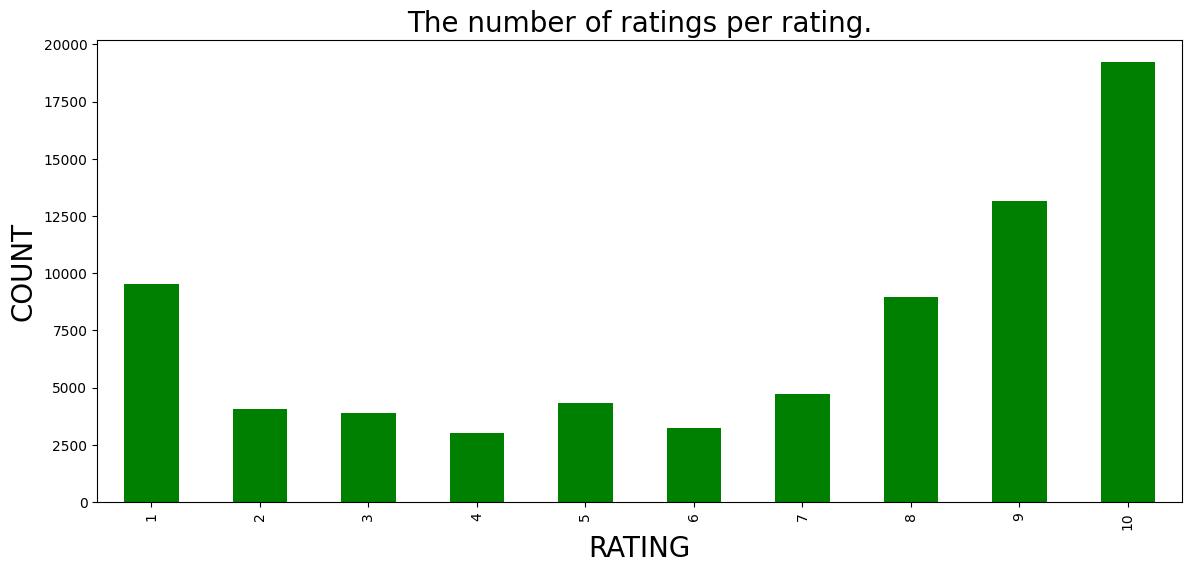

In [ ]:
ratings = dfAll.groupby(['rating'])['rating'].count()
ratings.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("RATING", fontsize = 20)
plt.ylabel("COUNT", fontsize = 20)
plt.title("The number of ratings per rating.", fontsize = 20)

#### Label Encoding
Since our condition and drugName columns are not numerical, we have to convert them to numerical values so we can use them for our model

In [ ]:
# Label encoding for the condition
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dfAll['condition'] = le.fit_transform(dfAll['condition'])
dfAll

,drugName,condition,review,rating,date,usefulCount
71707,yaz,0,"""i was on yaz for about a year. it cleared up ...",9,18-Jun-10,6
30498,bactrim ds,0,"""granddaughter in hospital thanks to this, eve...",1,15-Jul-17,0
20664,doxycycline,0,"""well i was 15 when i started getting acne n i...",7,10-Jul-16,6
67231,ethinyl estradiol / norethindrone,0,"""i love gildess! i&#039;ve been on spironolact...",10,15-Apr-16,2
67198,epiduo,0,"""had terrible acne on my chin and used this pr...",9,2009-Aug-12,11
...,...,...,...,...,...,...
89068,celecoxib,4,"""i have severe pain, stiffness, inflammation i...",10,14-Nov-17,0
31067,diclofenac,4,"""i have suffered from rotator cuff pain along ...",10,18-Apr-10,24
55446,hydrocodone,4,"""i&#039;m use to norco 10/325 and i take four ...",1,12-Jun-15,51
7832,tramadol,4,"""i was prescribed tramadol for my back pain. i...",2,2009-Mar-08,36


In [ ]:
# print the unique values of the condition
print(dfAll['condition'].unique())

[0 1 2 3 4]


In [ ]:
# Label encoding for the drugName
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dfAll['drugName'] = le.fit_transform(dfAll['drugName'])
dfAll

,drugName,condition,review,rating,date,usefulCount
71707,630,0,"""i was on yaz for about a year. it cleared up ...",9,18-Jun-10,6
30498,73,0,"""granddaughter in hospital thanks to this, eve...",1,15-Jul-17,0
20664,179,0,"""well i was 15 when i started getting acne n i...",7,10-Jul-16,6
67231,208,0,"""i love gildess! i&#039;ve been on spironolact...",10,15-Apr-16,2
67198,196,0,"""had terrible acne on my chin and used this pr...",9,2009-Aug-12,11
...,...,...,...,...,...,...
89068,117,4,"""i have severe pain, stiffness, inflammation i...",10,14-Nov-17,0
31067,165,4,"""i have suffered from rotator cuff pain along ...",10,18-Apr-10,24
55446,246,4,"""i&#039;m use to norco 10/325 and i take four ...",1,12-Jun-15,51
7832,557,4,"""i was prescribed tramadol for my back pain. i...",2,2009-Mar-08,36


In [ ]:
# print the unique values of the drugName
unique_drugName = dfAll['drugName'].unique()
#sort drugName
unique_drugName.sort()
print(unique_drugName)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

#### Dates Format

In [ ]:
dfAll['date'] = pd.to_datetime(dfAll['date'])

##### The date will have more importance if is near to 2023

In [ ]:
dfAll['year'] = dfAll['date'].dt.year
# Get the minimum year and maximum year
print("Minimum year: ", dfAll['year'].min())
print("Maximum year: ", dfAll['year'].max())

Minimum year:  2001
Maximum year:  2017


In [ ]:
# Knowing that the maximum year is 2017 and minimum is 2001, then give a rate from 0 to 1
# For each year
dfAll['year_importance'] = (dfAll['year'] - 2001) / (2017 - 2001)
dfAll

,drugName,condition,review,rating,date,usefulCount,year,year_importance
71707,630,0,"""i was on yaz for about a year. it cleared up ...",9,2010-06-18,6,2010,0.5625
30498,73,0,"""granddaughter in hospital thanks to this, eve...",1,2017-07-15,0,2017,1.0000
20664,179,0,"""well i was 15 when i started getting acne n i...",7,2016-07-10,6,2016,0.9375
67231,208,0,"""i love gildess! i&#039;ve been on spironolact...",10,2016-04-15,2,2016,0.9375
67198,196,0,"""had terrible acne on my chin and used this pr...",9,2009-08-12,11,2009,0.5000
...,...,...,...,...,...,...,...,...
89068,117,4,"""i have severe pain, stiffness, inflammation i...",10,2017-11-14,0,2017,1.0000
31067,165,4,"""i have suffered from rotator cuff pain along ...",10,2010-04-18,24,2010,0.5625
55446,246,4,"""i&#039;m use to norco 10/325 and i take four ...",1,2015-06-12,51,2015,0.8750
7832,557,4,"""i was prescribed tramadol for my back pain. i...",2,2009-03-08,36,2009,0.5000


#### Reviews

#### Sentiment Analysis
- As the reviews of the given medicine are text we need to convert them to numerical values. To do this a Sentiment analyssi is performed in each review of our data converting it to a numerical value

##### Making a Sentiment using each review rating
- As there are already several models for Natural Langue Processing we chose to use the HuggingFace library to perform our own sentiment analysis

In [ ]:
save = False # IF THE SENTIMENT ANALYSIS LIBRARY IS NOT INSTALLED, SET THIS TO FALSE
sentimentAnalysisFinished = True # SI QUIEREN CORRER TODO EL MODELO DE SENTIMENT ANALYSIS, SETEAR ESTO A FALSE, NO LES RECOMIENDO

In [ ]:
# For the sentiment analysis we are using a HuggingFace free model
if not save:
    # Preprocess text (username and link placeholders)
    def preprocess(text):
        new_text = []
    
    
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)

    # Tasks:
    # emoji, emotion, hate, irony, offensive, sentiment
    # stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

    task='sentiment'
    MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

    tokenizer = AutoTokenizer.from_pretrained(MODEL)



    # download label mapping
    labels=[]
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

    # # TF
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

    # PRUEBA DE SENTIMIENTO
    text = "Good night 😊"
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")

    saved = True


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


In [ ]:
# use the sentiment analysis model to predict the sentiment of each review
def sentiment_score(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

In [ ]:
# USING THE NOT REVIEW CLEAN
if not sentimentAnalysisFinished:
    # ALSO PRINT THE NUMBER OF REVIEW WHILE APLYING THE SENTIMENT ANALYSIS
    dfAll['sentiment_notClean'] = dfAll['review'].apply(sentiment_score)
    dfAll['sentiment_notClean'] = dfAll['sentiment_notClean'].apply(lambda x : 1 if np.argmax(x)==2 else -1 if np.argmax(x)==0 else 0)
    # save de df to a csv file
    dfAll.to_csv('dfAll_NotCleanReview.csv', index=False)
sentimentAnalysisFinished = True

In [ ]:
dfAll

,drugName,condition,review,rating,date,usefulCount,year,year_importance
71707,630,0,"""i was on yaz for about a year. it cleared up ...",9,2010-06-18,6,2010,0.5625
30498,73,0,"""granddaughter in hospital thanks to this, eve...",1,2017-07-15,0,2017,1.0000
20664,179,0,"""well i was 15 when i started getting acne n i...",7,2016-07-10,6,2016,0.9375
67231,208,0,"""i love gildess! i&#039;ve been on spironolact...",10,2016-04-15,2,2016,0.9375
67198,196,0,"""had terrible acne on my chin and used this pr...",9,2009-08-12,11,2009,0.5000
...,...,...,...,...,...,...,...,...
89068,117,4,"""i have severe pain, stiffness, inflammation i...",10,2017-11-14,0,2017,1.0000
31067,165,4,"""i have suffered from rotator cuff pain along ...",10,2010-04-18,24,2010,0.5625
55446,246,4,"""i&#039;m use to norco 10/325 and i take four ...",1,2015-06-12,51,2015,0.8750
7832,557,4,"""i was prescribed tramadol for my back pain. i...",2,2009-03-08,36,2009,0.5000


In [ ]:
#load the df from the csv file
df = pd.read_csv('dfAll_NotCleanReview.csv')
#Drop "review_clean"
df.drop(['review_clean'], axis=1, inplace=True)
#Drop "review"
df.drop(['review'], axis=1, inplace=True)
#Drop 'date'
df.drop(['date'], axis=1, inplace=True)
# from dfAll get the year_importance and put it in df
df['year_importance'] = dfAll.reset_index(drop=True)['year_importance']
# change the name of the column sentimetn_notClean to sentiment
df.rename(columns={'sentiment_notClean': 'sentiment'}, inplace=True)
df


,drugName,condition,rating,usefulCount,sentiment,year_importance
0,179,0,8,18,1,0.5625
1,263,0,8,2,1,1.0000
2,196,0,10,34,1,0.9375
3,196,0,8,11,-1,0.9375
4,196,0,9,4,1,0.5000
...,...,...,...,...,...,...
74087,473,4,7,26,1,1.0000
74088,248,4,9,21,1,0.5625
74089,423,4,8,9,1,0.8750
74090,346,4,10,3,0,0.5000


In [ ]:
# Check for missing values
df.isnull().sum()

drugName           0
condition          0
rating             0
usefulCount        0
sentiment          0
year_importance    0
dtype: int64

In [ ]:
# all columns have the same number of rows?
df.count()

drugName           74092
condition          74092
rating             74092
usefulCount        74092
sentiment          74092
year_importance    74092
dtype: int64

### Divide the data into train and test, and validate

In [2]:
# Divide the data into x_train, x_rem, y_train, y_rem, we want to predict the drugName
import fast_ml
from fast_ml.model_development import
X_train, y_train, X_valid, y_valid, X_test, y_test = (df, target='drugName',
                                                                            train_size=0.7, valid_size=0.1,
                                                                            test_size=0.2, random_state=42)

# Check the shape of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_valid shape: ", X_valid.shape)
print("y_valid shape: ", y_valid.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


ModuleNotFoundError: No module named 'fast_ml'

#### Feature Selection

- The Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with the best Chi-square scores. In order to correctly apply the chi-squared to test the relation between various features in the dataset and the target variable, the following conditions have to be met: the variables have to be categorical and be sampled independently.
- In this case we can not use the chi-square test for the sentiment analysis, it has negative values and the chi-square test only works with positive values.
  - But we can use it for the other features, and use a correlation matrix for the sentiment analysis. 

In [ ]:
# Chi-Squared Test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Three features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k = 3)
# X can not contain negative values
X_train = X_train.abs()
X_kbest_features = chi2_features.fit_transform(X_train, y_train)

# Reduced features
print('Original feature number:', X_train.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])

# Get selected feature index
selected_features = chi2_features.get_support(indices=True)
print('Selected feature index:', selected_features)

# Get selected feature names
selected_features_names = X_train.iloc[:,selected_features].columns.tolist()
print('Selected feature names:', selected_features_names)


Original feature number: 5
Reduced feature number: 3
Selected feature index: [0 1 2]
Selected feature names: ['condition', 'rating', 'usefulCount']


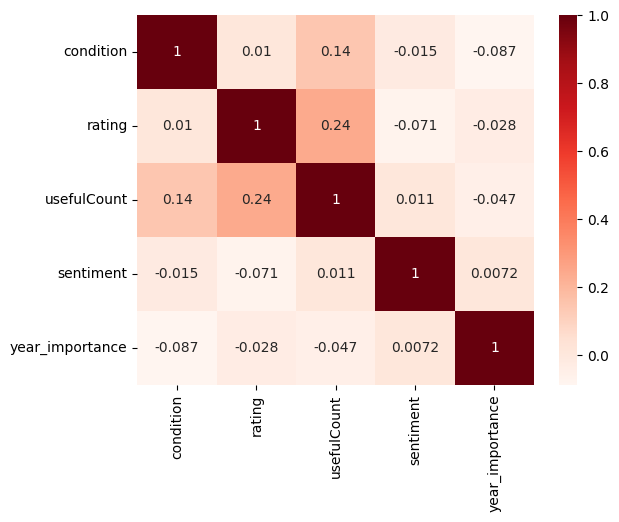

In [ ]:
# Correlation Matrix with Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
corr = X_train.corr()

# Heatmap
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()



- Since we are going to do repeated k-fold cross validation, we dont need to split the data into train, test and validation, we can use the whole data for training and testing.
- We are using then the dataframe that was instanciated before.
- After feature selection, we will use only 5 features, the ones that have the highest correlation with the target variable. Dropping the year importance.

In [ ]:
# Drop the columns that we don't need, sentiment and year_importance are not included
df.drop(['year_importance'], axis=1, inplace=True)
df

,drugName,condition,rating,usefulCount,sentiment
0,179,0,8,18,1
1,263,0,8,2,1
2,196,0,10,34,1
3,196,0,8,11,-1
4,196,0,9,4,1
...,...,...,...,...,...
74087,473,4,7,26,1
74088,248,4,9,21,1
74089,423,4,8,9,1
74090,346,4,10,3,0


In [ ]:
# all columns are now numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74092 entries, 0 to 74091
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   drugName     74092 non-null  int64
 1   condition    74092 non-null  int64
 2   rating       74092 non-null  int64
 3   usefulCount  74092 non-null  int64
 4   sentiment    74092 non-null  int64
dtypes: int64(5)
memory usage: 2.8 MB


#### Model Training

- All models must have repeated k-fold cross validation.

In [ ]:
# I want to divide the data only in X and Y.
# X will be all the columns except the target column
# Y will be the target column
Y = df['drugName']
X = df.drop(['drugName'], axis=1)


# Check the shape of the data
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (74092, 4)
Y shape:  (74092,)


#### Data Balancing

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X, Y = undersample.fit_resample(X, Y)

# Check the shape of the data
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)


X shape:  (69699, 4)
Y shape:  (69699,)


#### Logistic Regression

In [ ]:
logisticRegressionFinished = False

In [ ]:
# save X as a csv file
X.to_csv('X.csv', index=False)
X

,condition,rating,usefulCount,sentiment
0,3,2,47,-1
1,3,10,50,1
2,3,8,0,0
3,3,9,71,1
4,3,10,130,1
...,...,...,...,...
69694,3,1,12,-1
69695,3,10,61,1
69696,3,8,11,1
69697,3,6,72,1


In [ ]:
# save Y as a csv file
Y.to_csv('Y.csv', index=False)
Y

0          0
1          0
2          0
3          0
4          0
        ... 
69694    644
69695    644
69696    644
69697    644
69698    644
Name: drugName, Length: 69699, dtype: int64

In [ ]:
search = 0
if (not logisticRegressionFinished):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GridSearchCV

    model = LogisticRegression()

    scaler = StandardScaler()

    pipeline = Pipeline(steps=[('s', scaler), ('m', model)])

    params = {'m__penalty': ['l1', 'l2'], 'm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    search = GridSearchCV(pipeline, params, cv=cv, scoring='accuracy', n_jobs=-1)

    search.fit(X, Y)

    print("BEST HYPERPARAMETERS : ", search.best_params_)






huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/juancisneros/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juancisneros/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

BEST HYPERPARAMETERS :  {'m__C': 100, 'm__penalty': 'l2'}


fit_time: 0.36211864948272704 +/- 0.07109635896529118
score_time: 0.008868741989135741 +/- 0.0017196646159089817
test_accuracy: 0.08166666666666668 +/- 0.021615323782497968
test_roc_auc: nan +/- nan
test_precision_macro: 0.026408483495219105 +/- 0.01686063799188933
test_recall_macro: 0.05168134995097519 +/- 0.021276691990321325
test_f1_macro: 0.03190313942957075 +/- 0.01726471420110645
test_roc_auc_ovr_weighted: nan +/- nan


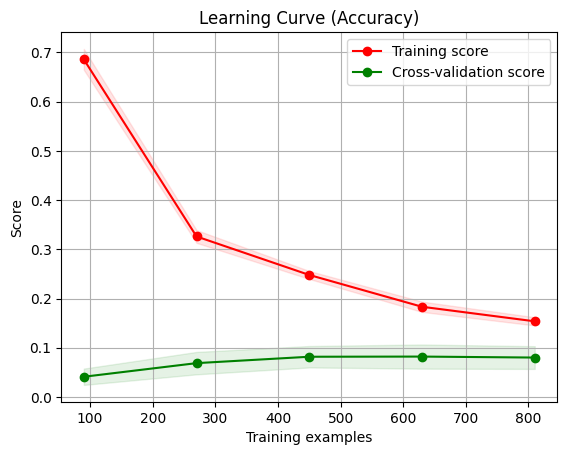

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, auc, roc_curve, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

import matplotlib.pyplot as plt
import numpy as np

# Define the final model
model = LogisticRegression(penalty=search.best_params_['m__penalty'], C=search.best_params_['m__C'])
scaler = StandardScaler()
pipeline = Pipeline(steps=[('s', scaler), ('m', model)])

# Define the training sizes you want to use
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]

# Define the cross-validation scheme you want to use
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Define the metrics you want to use to evaluate the model
scoring = {'accuracy': make_scorer(accuracy_score), 
           'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='weighted'),
           'precision_macro': make_scorer(precision_score, average='macro'), 
           'recall_macro': make_scorer(recall_score, average='macro'), 
           'f1_macro': make_scorer(f1_score, average='macro'), 
           'roc_auc_ovr_weighted': make_scorer(roc_auc_score, multi_class='ovr', average='weighted')}

# Calculate the scores using cross-validation
scores = cross_validate(pipeline, X, Y, cv=cv, scoring=scoring)

# Print the scores
for metric_name, metric_score in scores.items():
    print(f"{metric_name}: {np.mean(metric_score)} +/- {np.std(metric_score)}")

# Plot the learning curve for accuracy
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, Y, cv=cv, scoring='accuracy', train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title('Learning Curve (Accuracy)')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
# Plot the learning curve for ROC


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#### SVM

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# create a pipeline with a scaler and an SVM classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# define the grid of hyperparameters to search over
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# define the cross-validation strategy
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring='accuracy')

# fit the model to the data
grid_search.fit(X, Y)

# print the results
print("Best score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Best score: 0.09
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


fit_time: 0.2653968811035156 +/- 0.024031125406047044
score_time: 0.046765557924906415 +/- 0.0049875282067832274
test_accuracy: 0.10133333333333332 +/- 0.028720878971384024
test_roc_auc: nan +/- nan
test_precision_macro: 0.03524201931762162 +/- 0.01107802036629729
test_recall_macro: 0.06794810125123316 +/- 0.021164612673982702
test_f1_macro: 0.04292016478273737 +/- 0.013287631615934187
test_roc_auc_ovr_weighted: nan +/- nan


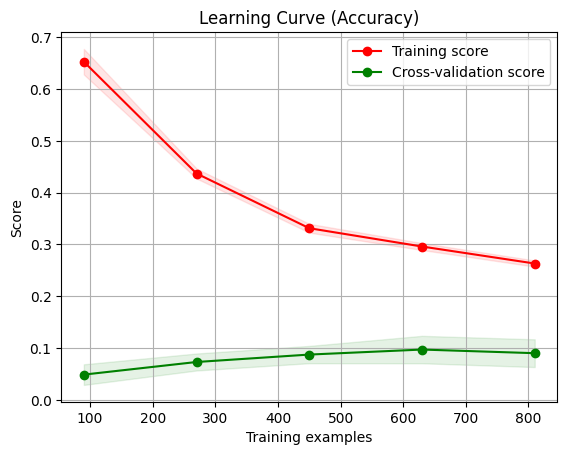

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, RepeatedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# define el pipeline con los mejores parámetros encontrados
model = SVC(C=grid_search.best_params_['svm__C'], kernel=grid_search.best_params_['svm__kernel'], gamma=grid_search.best_params_['svm__gamma'])
scaler = StandardScaler()
pipeline = Pipeline(steps=[('s', scaler), ('m', model)])

# define the training sizes you want to use
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]

# define the cross-validation scheme you want to use
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Define the metrics you want to use to evaluate the model
scoring = {'accuracy': make_scorer(accuracy_score), 
           'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='weighted'),
           'precision_macro': make_scorer(precision_score, average='macro'), 
           'recall_macro': make_scorer(recall_score, average='macro'), 
           'f1_macro': make_scorer(f1_score, average='macro'), 
           'roc_auc_ovr_weighted': make_scorer(roc_auc_score, multi_class='ovr', average='weighted')}

# Calculate the scores using cross-validation
scores = cross_validate(pipeline, X, Y, cv=cv, scoring=scoring)

# Print the scores
for metric_name, metric_score in scores.items():
    print(f"{metric_name}: {np.mean(metric_score)} +/- {np.std(metric_score)}")

# Plot the learning curve for accuracy
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, Y, cv=cv, scoring='accuracy', train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title('Learning Curve (Accuracy)')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()


In [ ]:
# FALTA ROC 


### CONCLUSIONES
- ESTA PARTE LA DEJAMOS PARA LA ENTREGA FINAL

### REFERENCIAS
- A. Kanumuru, “Scikit-learn pipeline tutorial with parameter tuning and cross-validation,” Medium, 17-Aug-2021. [Online]. Available: https://towardsdatascience.com/scikit-learn-pipeline-tutorial-with-parameter-tuning-and-cross-validation-e5b8280c01fb. [Accessed: 07-May-2023].
- A. Nair, “K-fold cross validation: Are you doing it right?,” Medium, 28-Nov-2022. [Online]. Available: https://towardsdatascience.com/k-fold-cross-validation-are-you-doing-it-right-e98cdf3e6690. [Accessed: 07-May-2023].
- A. Navlani, “Scikit-learn SVM tutorial with Python (Support Vector Machines),” DataCamp, 27-Dec-2019. [Online]. Available: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python. [Accessed: 07-May-2023].
- F. Pascual, “Getting started with sentiment analysis using Python,” Hugging Face – The AI community building the future. [Online]. Available: https://huggingface.co/blog/sentiment-analysis-python. [Accessed: 07-May-2023].
- “Learn,” scikit. [Online]. Available: https://scikit-learn.org/stable/index.html. [Accessed: 07-May-2023].